# 🚀 Caso aplicado: Agrupar start-ups por éxito e innovación
**Técnica:** K-Means Clustering**

**Objetivo:** Segmentar start-ups según su desempeño, innovación y sector tecnológico para identificar patrones de éxito.

## 0️⃣ Preparación del entorno
**Objetivo:** Cargar librerías y fijar semilla para reproducibilidad.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(42)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

## 1️⃣ Simulación de datos
**Objetivo:** Generar base simulada de start-ups con métricas de innovación y éxito.

In [63]:
n = 500
sectores = np.random.choice(['IA', 'Fintech', 'Salud', 'EdTech', 'E-commerce', 'ClimaTech'], size=n, p=[0.18, 0.20, 0.16, 0.16, 0.20, 0.10])
etapa = np.random.choice(['Pre-Seed', 'Seed', 'Series A', 'Series B'], size=n, p=[0.25, 0.35, 0.25, 0.15])

sector_factor = pd.Series(sectores).map({'IA': 1.15, 'Fintech': 1.10, 'Salud': 1.05, 'EdTech': 0.95, 'E-commerce': 1.00, 'ClimaTech': 1.08}).values
innovacion = np.clip(np.random.beta(a=2, b=2, size=n) * sector_factor, 0, 1)
uso_ia = ((sectores=='IA') | (np.random.rand(n) < 0.25)).astype(int)
modelo_saas = (np.random.rand(n) < 0.55).astype(int)
acelerada = (np.random.rand(n) < 0.35).astype(int)

ingresos_mensuales = np.random.lognormal(mean=10, sigma=0.6, size=n) * (0.8 + 0.4*modelo_saas)
crec_ingresos = np.random.normal(loc=0.08, scale=0.06, size=n) + 0.04*innovacion
usuarios_mensuales = np.random.lognormal(mean=11, sigma=0.8, size=n) * (1 + 0.3*uso_ia)
crec_usuarios = np.random.normal(loc=0.10, scale=0.07, size=n) + 0.03*innovacion
churn = np.clip(np.random.normal(loc=0.06, scale=0.03, size=n) - 0.01*modelo_saas - 0.01*innovacion, 0.0, 0.25)
nps = np.clip(np.random.normal(loc=35, scale=15, size=n) + 20*innovacion - 10*churn, -100, 100)

funding_total = np.random.lognormal(mean=15, sigma=0.9, size=n) * (1 + 0.2*acelerada)
burn_mensual = np.random.lognormal(mean=11, sigma=0.7, size=n)
runway_meses = np.clip((funding_total / (burn_mensual + 1e-6)), 2, 36)

tam_equipo = np.clip((np.random.normal(20, 12, n) + 15*(etapa=='Series A') + 25*(etapa=='Series B')), 3, None)
experiencia_fundadores = np.clip(np.random.normal(7, 3.5, n) + 1.5*acelerada + 1.0*(sectores=='Fintech'), 0, 25)
valuacion_proxy = (ingresos_mensuales*12)*(1 + 8*crec_ingresos) * (1 + 0.6*innovacion)

df = pd.DataFrame({
    'sector': sectores, 'etapa': etapa, 'innovacion': innovacion,
    'uso_ia': uso_ia, 'modelo_saas': modelo_saas, 'acelerada': acelerada,
    'ingresos_mensuales': ingresos_mensuales, 'crec_ingresos': crec_ingresos,
    'usuarios_mensuales': usuarios_mensuales, 'crec_usuarios': crec_usuarios,
    'churn': churn, 'nps': nps, 'funding_total': funding_total,
    'burn_mensual': burn_mensual, 'runway_meses': runway_meses,
    'tam_equipo': tam_equipo, 'experiencia_fundadores': experiencia_fundadores,
    'valuacion_proxy': valuacion_proxy
})
df.head()

,sector,etapa,innovacion,uso_ia,modelo_saas,acelerada,ingresos_mensuales,crec_ingresos,usuarios_mensuales,crec_usuarios,churn,nps,funding_total,burn_mensual,runway_meses,tam_equipo,experiencia_fundadores,valuacion_proxy
0,Fintech,Series A,0.88,0,1,1,"34,924.49",0.07,"542,625.24",0.24,0.04,43.37,"7,263,170.41","143,601.49",36.00,37.32,5.99,"992,801.67"
1,ClimaTech,Seed,0.45,1,1,1,"18,996.13",0.11,"60,954.06",0.14,0.06,34.14,"2,685,137.84","28,579.70",36.00,20.72,11.81,"544,996.93"
2,E-commerce,Seed,0.41,0,1,0,"31,956.68",0.07,"107,448.53",0.03,0.04,27.14,"7,871,728.59","127,090.55",36.00,21.27,7.53,"740,552.15"
3,EdTech,Series A,0.72,0,0,0,"10,360.00",0.12,"35,577.62",0.22,0.11,58.76,"1,180,048.12","124,628.61",9.47,27.35,3.42,"348,756.22"
4,IA,Series A,0.78,1,1,1,"29,465.02",0.20,"14,619.65",0.08,0.00,72.37,"1,459,051.21","109,579.56",13.31,34.31,6.28,"1,357,994.71"


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sector                  500 non-null    object 
 1   etapa                   500 non-null    object 
 2   innovacion              500 non-null    float64
 3   uso_ia                  500 non-null    int64  
 4   modelo_saas             500 non-null    int64  
 5   acelerada               500 non-null    int64  
 6   ingresos_mensuales      500 non-null    float64
 7   crec_ingresos           500 non-null    float64
 8   usuarios_mensuales      500 non-null    float64
 9   crec_usuarios           500 non-null    float64
 10  churn                   500 non-null    float64
 11  nps                     500 non-null    float64
 12  funding_total           500 non-null    float64
 13  burn_mensual            500 non-null    float64
 14  runway_meses            500 non-null    fl

In [64]:
#Guardamos la base de datos generada
df.to_csv('startups_data.csv', index=False)

## 2️⃣ EDA - Exploración inicial de datos

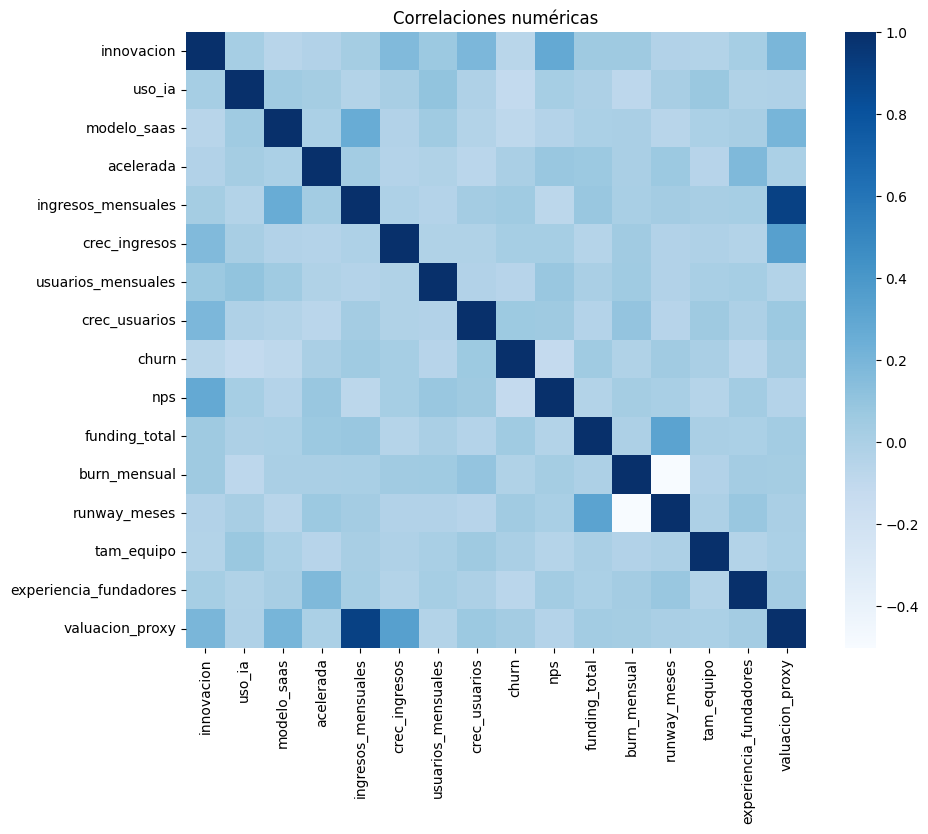

In [65]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes('number').corr(), cmap='Blues')
plt.title('Correlaciones numéricas')
plt.show()

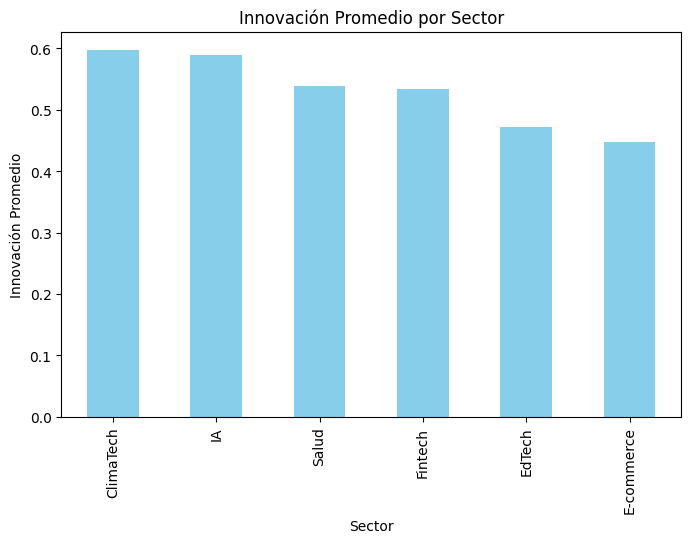

In [74]:
#Sectores con mayor innovación promedio
df.groupby('sector')['innovacion'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title('Innovación Promedio por Sector')
plt.ylabel('Innovación Promedio')
plt.xlabel('Sector')
plt.show()

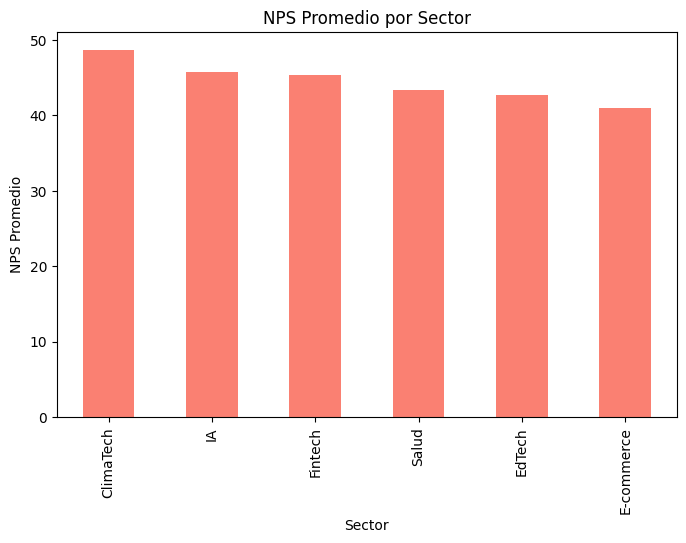

In [76]:
#Sectores con mayor nps promedio
df.groupby('sector')['nps'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(8,5), color='salmon')
plt.title('NPS Promedio por Sector')
plt.ylabel('NPS Promedio')
plt.xlabel('Sector')
plt.show()

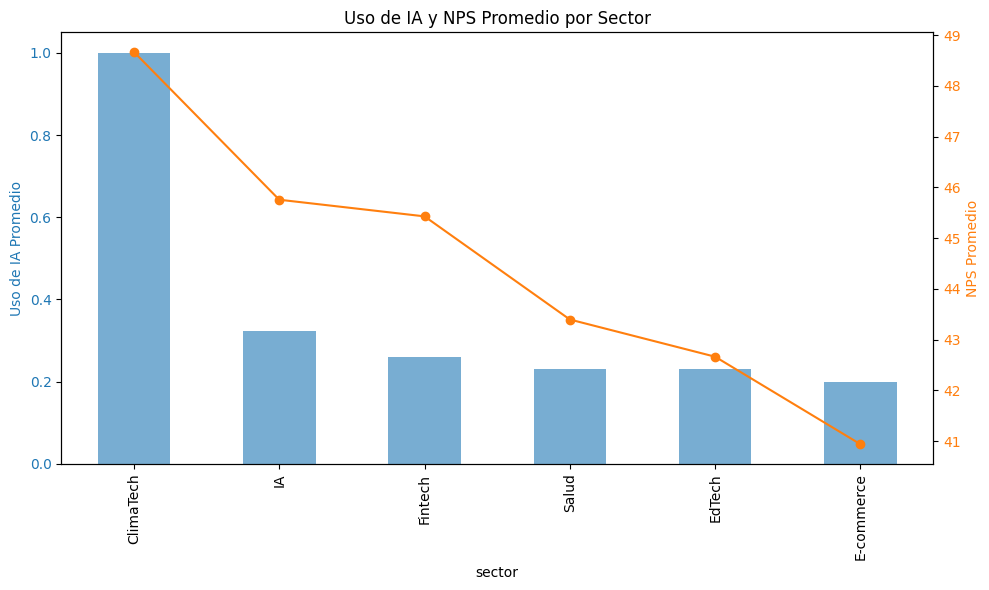

In [77]:
# Sectores con mayor uso_ia promedio y nps promedio
uso_ia_sector = df.groupby('sector')['uso_ia'].mean().sort_values(ascending=False)
nps_sector = df.groupby('sector')['nps'].mean().sort_values(ascending=False)   
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:blue'
ax1.set_xlabel('Sector')
ax1.set_ylabel('Uso de IA Promedio', color=color)
uso_ia_sector.plot(kind='bar', ax=ax1, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('NPS Promedio', color=color)
nps_sector.plot(kind='line', ax=ax2, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Uso de IA y NPS Promedio por Sector')
fig.tight_layout()
plt.show()

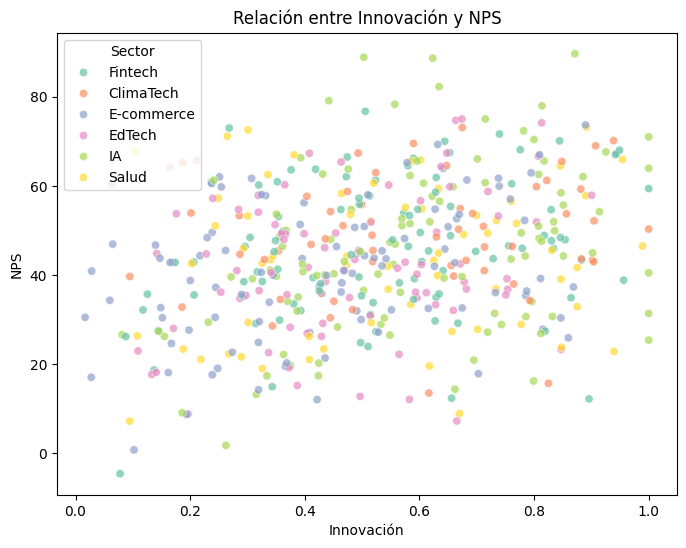

In [78]:
# Correlación entre innovación y nps  
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='innovacion', y='nps', hue='sector', palette='Set2', alpha=0.7)
plt.title('Relación entre Innovación y NPS')
plt.xlabel('Innovación')
plt.ylabel('NPS')
plt.legend(title='Sector')
plt.show()

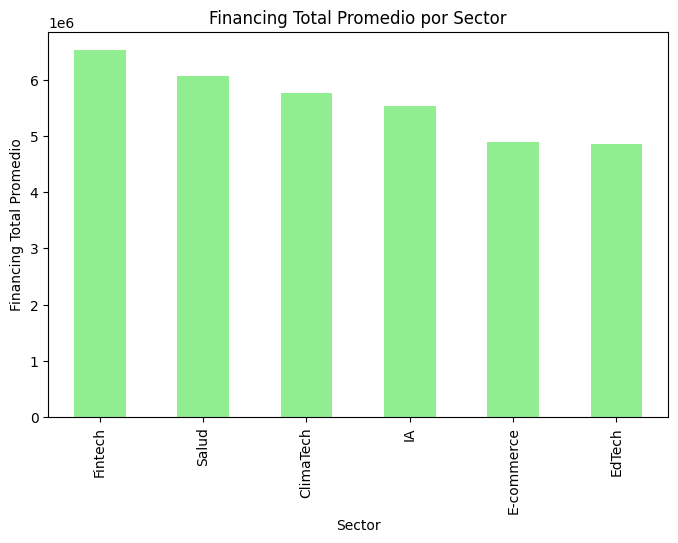

In [80]:
# Sector con mayor financing total promedio
df.groupby('sector')['funding_total'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(8,5), color='lightgreen')
plt.title('Financing Total Promedio por Sector')
plt.ylabel('Financing Total Promedio')
plt.xlabel('Sector')
plt.show()

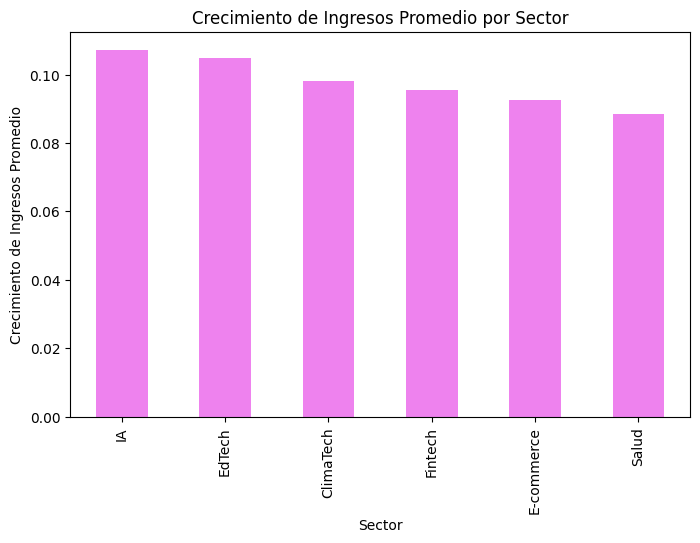

In [81]:
# Sectores con mayor crecimiento de ingresos promedio
df.groupby('sector')['crec_ingresos'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(8,5), color='violet')
plt.title('Crecimiento de Ingresos Promedio por Sector')
plt.ylabel('Crecimiento de Ingresos Promedio')
plt.xlabel('Sector')
plt.show()

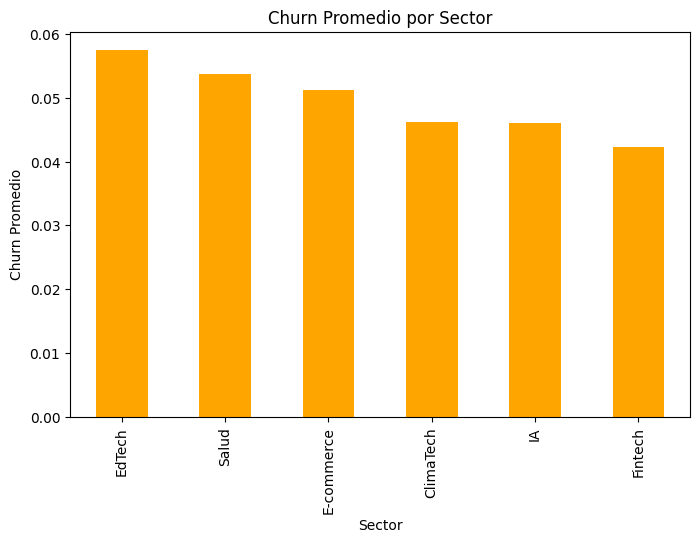

In [83]:
#Sectores con mayor churn promedio
df.groupby('sector')['churn'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(8,5), color='orange')
plt.title('Churn Promedio por Sector')
plt.ylabel('Churn Promedio')
plt.xlabel('Sector')
plt.show()

## 3️⃣ Preprocesamiento (One-hot + Escalamiento)

In [66]:
cat_cols = ['sector', 'etapa']
num_cols = [c for c in df.columns if c not in cat_cols]

prepro = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols)
], remainder='drop')

X = prepro.fit_transform(df)
X.shape

(500, 24)

## 4️⃣ Selección de K (Codo y Silueta)

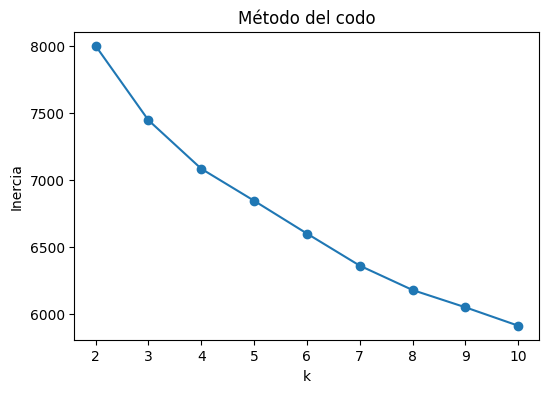

{2: np.float64(0.09994699753353486),
 3: np.float64(0.101722286320955),
 4: np.float64(0.06979018824644874),
 5: np.float64(0.06342007084695196),
 6: np.float64(0.06420397687860517),
 7: np.float64(0.07041766675809874),
 8: np.float64(0.07228955132358061),
 9: np.float64(0.06415094785675489),
 10: np.float64(0.07018083780262988)}

In [67]:
inertias = []
sil_vals = {}
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)
    labels = km.predict(X)
    sil_vals[k] = silhouette_score(X, labels)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.title('Método del codo')
plt.xlabel('k'); plt.ylabel('Inercia')
plt.show()

sil_vals

## 5️⃣ Entrenamiento del modelo K-Means

In [68]:
k_elegido = 3  # Ajustar según resultados
kmeans = KMeans(n_clusters=k_elegido, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

df_clusters = df.copy()
df_clusters['cluster'] = labels

sil = silhouette_score(X, labels)
print(f'Coeficiente de silueta (k={k_elegido}): {sil:.3f}')
df_clusters.head()

Coeficiente de silueta (k=3): 0.102


,sector,etapa,innovacion,uso_ia,modelo_saas,acelerada,ingresos_mensuales,crec_ingresos,usuarios_mensuales,crec_usuarios,churn,nps,funding_total,burn_mensual,runway_meses,tam_equipo,experiencia_fundadores,valuacion_proxy,cluster
0,Fintech,Series A,0.88,0,1,1,"34,924.49",0.07,"542,625.24",0.24,0.04,43.37,"7,263,170.41","143,601.49",36.00,37.32,5.99,"992,801.67",1
1,ClimaTech,Seed,0.45,1,1,1,"18,996.13",0.11,"60,954.06",0.14,0.06,34.14,"2,685,137.84","28,579.70",36.00,20.72,11.81,"544,996.93",0
2,E-commerce,Seed,0.41,0,1,0,"31,956.68",0.07,"107,448.53",0.03,0.04,27.14,"7,871,728.59","127,090.55",36.00,21.27,7.53,"740,552.15",0
3,EdTech,Series A,0.72,0,0,0,"10,360.00",0.12,"35,577.62",0.22,0.11,58.76,"1,180,048.12","124,628.61",9.47,27.35,3.42,"348,756.22",2
4,IA,Series A,0.78,1,1,1,"29,465.02",0.20,"14,619.65",0.08,0.00,72.37,"1,459,051.21","109,579.56",13.31,34.31,6.28,"1,357,994.71",2


## 6️⃣ Perfilamiento de clústeres

In [95]:
# ...existing code...
# Select numeric columns for aggregation (más robust)
numeric_cols = df_clusters.select_dtypes(include='number').columns
if 'cluster' in numeric_cols:
    numeric_cols = numeric_cols.difference(['cluster'])
numeric_cols = numeric_cols.tolist()
# ...existing code...

# Calculate mean and median for numeric columns
resumen = df_clusters.groupby('cluster')[numeric_cols].agg(['mean', 'median']).round(2)

# Calculate sector and stage distribution per cluster
sector_mix = pd.crosstab(df_clusters['cluster'], df_clusters['sector'], normalize='index').round(2)
etapa_mix = pd.crosstab(df_clusters['cluster'], df_clusters['etapa'], normalize='index').round(2)

# Display results
resumen.head(10), sector_mix, etapa_mix

(        acelerada        burn_mensual            churn        crec_ingresos  \
              mean median         mean     median  mean median          mean   
 cluster                                                                       
 0            0.38   0.00    56,553.64  48,046.98  0.05   0.05          0.09   
 1            0.33   0.00    65,533.13  54,852.97  0.05   0.05          0.11   
 2            0.30   0.00   148,725.71 131,182.76  0.05   0.04          0.10   
 
                crec_usuarios         ... runway_meses        tam_equipo  \
         median          mean median  ...         mean median       mean   
 cluster                              ...                                  
 0         0.09          0.10   0.10  ...        34.80  36.00      26.58   
 1         0.11          0.12   0.12  ...        34.35  36.00      30.60   
 2         0.11          0.12   0.12  ...        14.40  13.73      26.60   
 
                uso_ia        usuarios_mensuales           v

In [70]:
#Centros originales del modelo KMeans
centros = kmeans.cluster_centers_
centros_df = pd.DataFrame(centros, columns=prepro.get_feature_names_out())
centros_df.head()

,cat__sector_E-commerce,cat__sector_EdTech,cat__sector_Fintech,cat__sector_IA,cat__sector_Salud,cat__etapa_Seed,cat__etapa_Series A,cat__etapa_Series B,num__innovacion,num__uso_ia,...,num__usuarios_mensuales,num__crec_usuarios,num__churn,num__nps,num__funding_total,num__burn_mensual,num__runway_meses,num__tam_equipo,num__experiencia_fundadores,num__valuacion_proxy
0,0.19,0.17,0.22,0.19,0.11,0.38,0.20,0.12,-0.10,0.03,...,-0.03,-0.10,-0.04,0.10,0.07,-0.33,0.47,-0.05,0.01,-0.41
1,0.12,0.14,0.19,0.27,0.20,0.29,0.30,0.21,0.26,0.04,...,-0.05,0.20,0.18,-0.18,0.34,-0.19,0.42,0.22,0.15,1.56
2,0.28,0.16,0.12,0.19,0.14,0.36,0.21,0.13,0.07,-0.12,...,0.12,0.13,-0.04,-0.13,-0.48,1.10,-1.67,-0.05,-0.14,-0.08


In [94]:
# Nivel promedio de innovación por cluster, crecimiento de ingresos, churn, crecimiento de usuarios, nps, uso_ia, tam_equipo
# Nivel promedio de innovación por cluster, crecimiento de ingresos, churn, crecimiento de usuarios, nps, uso_ia, tam_equipo
cluster_summary = df_clusters.groupby('cluster').agg({
    'innovacion': 'mean',
    'crec_ingresos': 'mean',
    'churn': 'mean',
    'crec_usuarios': 'mean',
    'nps': 'mean',
    'uso_ia': 'mean',
    'tam_equipo': 'mean',
    'runway_meses': 'mean', 
}).round(3)
cluster_summary

,innovacion,crec_ingresos,churn,crec_usuarios,nps,uso_ia,tam_equipo,runway_meses
cluster,,,,,,,,
0,0.50,0.09,0.05,0.10,45.82,0.42,26.58,34.80
1,0.58,0.12,0.06,0.12,41.35,0.43,30.60,34.34
2,0.54,0.10,0.05,0.12,42.10,0.35,26.59,14.40


## 7️⃣ Visualización de resultados

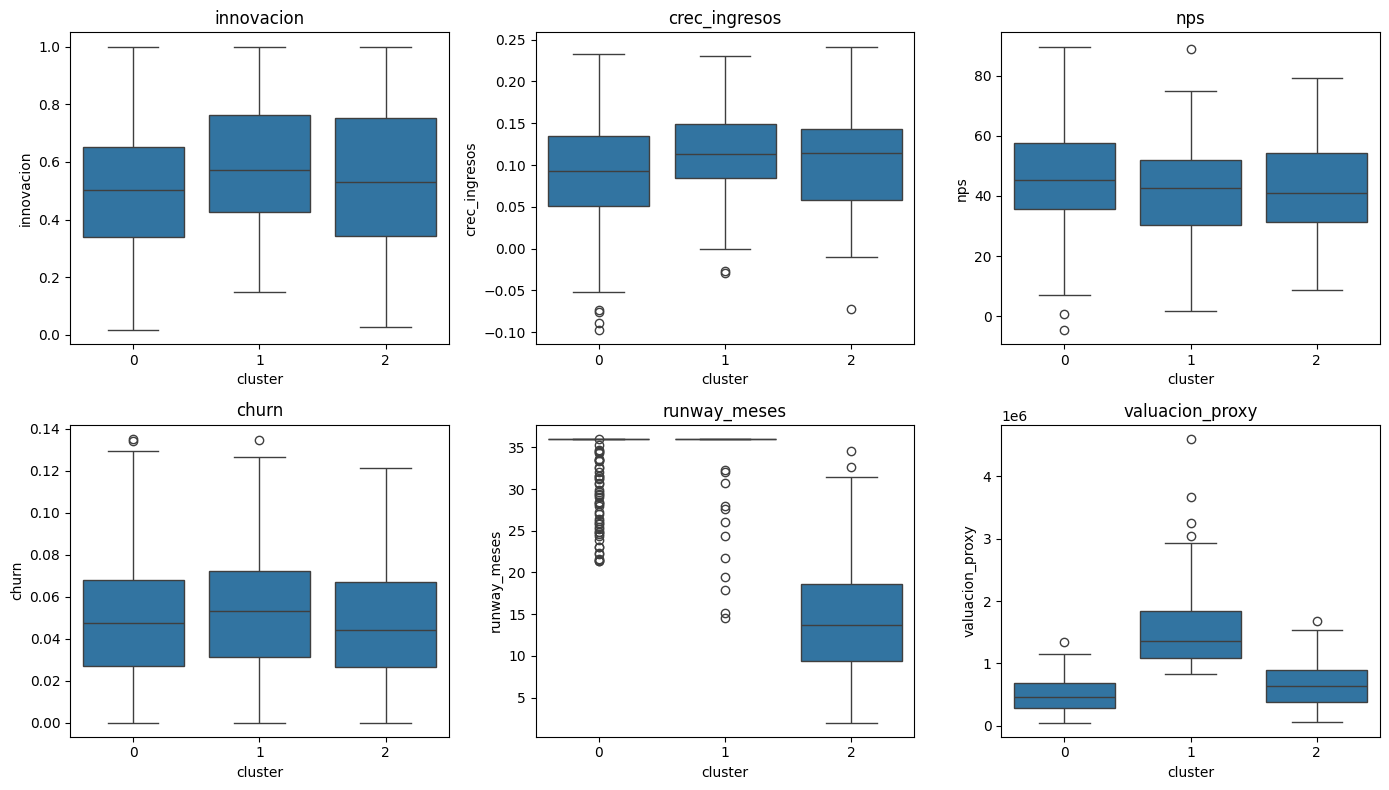

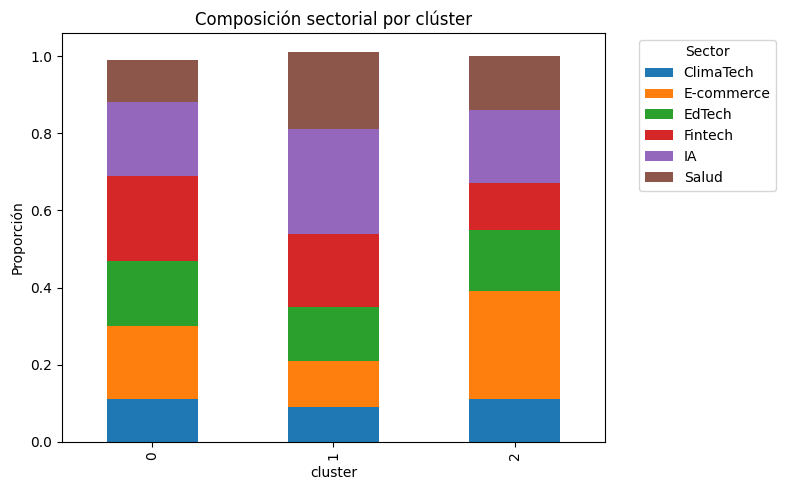

In [71]:
vars_clave = ['innovacion','crec_ingresos','nps','churn','runway_meses','valuacion_proxy']
fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes = axes.ravel()
for i, col in enumerate(vars_clave):
    sns.boxplot(data=df_clusters, x='cluster', y=col, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout(); plt.show()

sector_mix.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Composición sectorial por clúster')
plt.ylabel('Proporción'); plt.legend(title='Sector', bbox_to_anchor=(1.05,1))
plt.tight_layout(); plt.show()

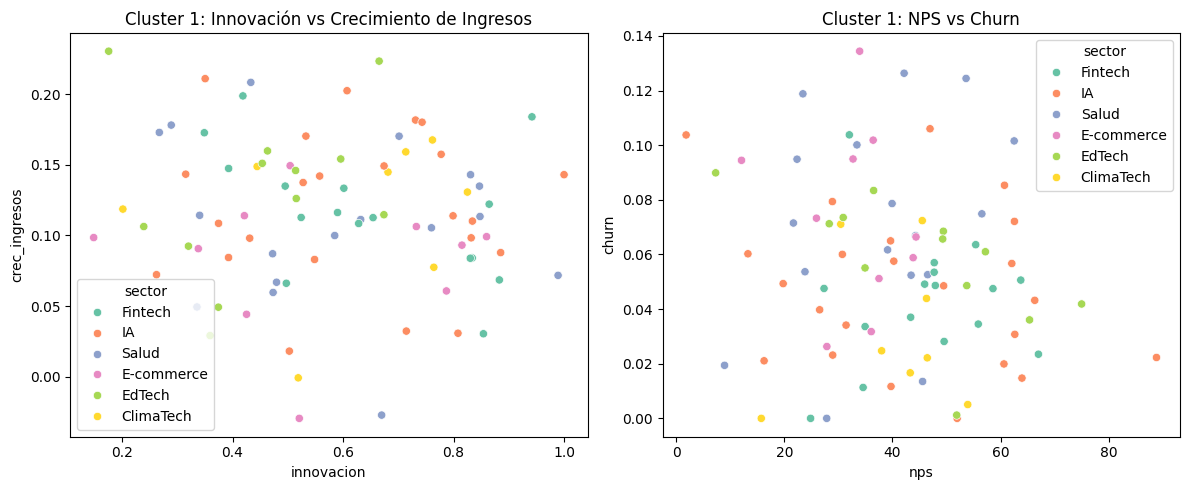

In [72]:
# visualizamos el cluster 1 en diagramas de dispersión
cluster_id = 1
df_c1 = df_clusters[df_clusters['cluster'] == cluster_id]
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(data=df_c1, x='innovacion', y='crec_ingresos', hue='sector', palette='Set2')
plt.title(f'Cluster {cluster_id}: Innovación vs Crecimiento de Ingresos')

plt.subplot(1,2,2)
sns.scatterplot(data=df_c1, x='nps', y='churn', hue='sector', palette='Set2')
plt.title(f'Cluster {cluster_id}: NPS vs Churn')

plt.tight_layout()
plt.show()

## 8️⃣ Recomendaciones estratégicas
Redacta 2–3 estrategias para cada clúster según sus características.

In [96]:
# 9.1 Silueta con distintas semillas
def silueta_con_semilla(seed, k):
    km = KMeans(n_clusters=k, random_state=seed, n_init=10)
    labs = km.fit_predict(X)
    return silhouette_score(X, labs)

for s in [0, 7, 42, 100]:
    print(f'Semilla {s}: silueta = {silueta_con_semilla(s, k_elegido):.3f}')

Semilla 0: silueta = 0.102
Semilla 7: silueta = 0.101
Semilla 42: silueta = 0.102
Semilla 100: silueta = 0.098


In [97]:
# 9.2 Probar k cercanos y discutir interpretabilidad
for k in [max(2, k_elegido-1), k_elegido, k_elegido+1]:
    labs = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    print(f'k={k}: silueta = {silhouette_score(X, labs):.3f}')

k=2: silueta = 0.100
k=3: silueta = 0.102
k=4: silueta = 0.070


## 9️⃣ Exportar resultados

In [73]:
df_clusters.to_csv('startups_clusters.csv', index=False)
resumen.to_csv('resumen_kpis_por_cluster.csv')
sector_mix.to_csv('mix_sector_por_cluster.csv')
etapa_mix.to_csv('mix_etapa_por_cluster.csv')